# Implémentez un modèle de scoring

- **Projet 7 du parcours « Data Scientist » d’OpenClassrooms**
- **Mark Creasey**

## Étape 2 : Modélisation


## 1.1 Compréhension du problème

### 1.1.1 Problématique

La société financière, nommée **"Prêt à dépenser"**, propose des crédits à la consommation pour des
personnes ayant peu ou pas du tout d'historique de prêt.

L’entreprise souhaite mettre en œuvre **un outil de “scoring crédit”** pour calculer la qu’un client
rembourse son crédit, puis classifie la demande en crédit accordé ou refusé. Elle souhaite donc
développer **un algorithme de classification** en s’appuyant sur des sources de données variées (données
comportementales, données provenant d'autres institutions financières, etc.).

### 1.1.2 Les données

Voici [les données](https://www.kaggle.com/c/home-credit-default-risk/data) pour réaliser le
dashboard. Pour plus de simplicité, vous pouvez les télécharger à
[cette adresse](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Impl%C3%A9menter+un+mod%C3%A8le+de+scoring/Projet+Mise+en+prod+-+home-credit-default-risk.zip).

### 1.1.1 Mission

- Sélectionner un kernel Kaggle pour faciliter la préparation des données nécessaires à l’élaboration du modèle de scoring.
- Analyser ce kernel et l’adapter aux besoins de votre mission.

Focalise sur :

1. La construction d'un **modèle de scoring** qui donnera une prédiction sur la probabilité de faillite
   d'un client de façon automatique.
   - élaboration
   - optimisation
   - comprehension (interpretabilité)
2. Construction d'un **dashboard interactif** qui montre avec transparence les décisions d’octroi de
   crédit, à destination des gestionnaires de la relation client permettant d'interpréter les
   prédictions faites par le modèle et d’améliorer la connaissance client des chargés de relation
   client.


## 1.2 Definition de l'environnement

- `local` : Développement local (avec échantillon de 50 Mo de données)
- `colab` : Google Colab
- `kaggle` : Kaggle Kernel


In [1]:
ENV = 'local'

if ENV == 'local':
    # local development
    DATA_FOLDER = '../data/raw'
    OUT_FOLDER = '../data/out'
    IMAGE_FOLDER = '../images/modelisation'

if ENV == 'colab':
    # Colaboratory - uncomment les 2 lignes suivant pour connecter à votre drive
    # from google.colab import drive
    # drive.mount('/content/drive')
    DATA_FOLDER = '/content/drive/MyDrive/data/OC7'
    OUT_FOLDER = '/content/drive/MyDrive/data/OC7'
    IMAGE_FOLDER = '/content/drive/MyDrive/images/OC7/modelisation'


## 1.3 Fichiers de données

1. Les données en format CSV (>700Mb compactés) sont à télecharger de ce lien:

- https://www.kaggle.com/c/home-credit-default-risk/data
- Pour plus de simplicité, vous pouvez les télécharger à [cette adresse.](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Impl%C3%A9menter+un+mod%C3%A8le+de+scoring/Projet+Mise+en+prod+-+home-credit-default-risk.zip)

2.  Placer le fichier compacté (**.zip**) dans le **DATA_FOLDER** défini ci-dessous


### Noms des fichiers de données (identique pour nettoyage et l'analyse exploratoire)

- Le grand fichier zip des données doit être placé dans `DATA_FOLDER` au préalable
- Tous les autres fichiers de données sont téléchargés ou crées pendant le nettoyage, puis enregistrés dans `OUT_FOLDER`


In [2]:
# Données (DATA_FOLDER)
ZIPPED_DATA_FILENAME = f'Projet+Mise+en+prod+-+home-credit-default-risk.zip'
RAW_DATA_FILENAME = 'HomeCredit_columns_description.csv'
SAMPLE_DATA_FILENAME = 'HomeCredit_columns_description.csv'


# Données nettoyés (OUT_FOLDER)
CLEAN_DATA_FILENAME = 'cleaned_data_scoring.csv'
CLEAN_DATA_SAMPLE = 'cleaned_data_sample.csv'  # 100,000 registres
CLEAN_DATA_FEATURES = 'cleaned_data_features.csv'  # 100 meilleur features
SAMPLE_SIZE = 10000


## 1.4 Requirements: Bibliothèques utilisées dans ce notebook

Ce notebook marche a été testé en developpement local, sur Google Colab et Kaggle

```txt
# copy dans un fichier requirements.txt, puis
# !pip install -r requirements.txt
```


In [3]:
# Decommentarise la ligne suivant si vous ne voulez pas changer vos versions existants
# !pip install numpy pandas matplotlib seaborn scipy sklearn missingno requests


In [4]:
# import local functions
import outils_io
outils_io.install_libraries({'numpy', 'pandas', 'matplotlib',
                             'seaborn', 'sklearn'})


required modules: ['numpy', 'pandas', 'matplotlib', 'sklearn', 'seaborn']
missing modules: []


## 1.5 Import dependencies


### 1.5.1 Import des bibliothèques utilisées par ce notebook


In [5]:
# suppress furture warnings de pandas 1.3.0
from contextlib import contextmanager
import time as time_module
import gc
import os
import warnings
import platform
warnings.simplefilter(action='ignore', category=FutureWarning)


In [6]:
import sklearn
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# feature preprocessing
from sklearn import impute
from sklearn import preprocessing

# feature et parameter selection
from sklearn.model_selection import train_test_split, GridSearchCV

# Sampling (SMOTE : Synthetic Minority Oversampling TEchnique)
from imblearn import pipeline as imbpipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTETomek

# metrics de performance
from sklearn import metrics
from sklearn.metrics import make_scorer, roc_auc_score


# Candidate models
from sklearn.base import BaseEstimator
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier


### 1.5.2 Liste des versions des bibliothèques utilisées


In [7]:
print(f'python version = {platform.python_version()}')
print('versions des bibliothèques utilisées:')
print('; '.join(f'{m.__name__}=={m.__version__}' for m in globals(
).values() if getattr(m, '__version__', None)))


python version = 3.7.0
versions des bibliothèques utilisées:
platform==1.0.8; sklearn==1.0.2; seaborn==0.11.2; pandas==1.1.5; numpy==1.21.5


### 1.5.3 Configuration défauts d'affichage


In [8]:
from sklearn import set_config
pd.set_option('display.max_columns', 200)  # pour afficher toutes les colonnes
pd.set_option('display.max_rows', 20)  # pour afficher max 20 lignes
pd.set_option('display.max_colwidth', 800)

%matplotlib inline
sns.set_theme(style="white", context="notebook")
sns.set_color_codes("pastel")
sns.set_palette("tab20")

set_config(display='diagram')
# displays HTML representation in a jupyter context


### Bibliothèque personelle

On utilise un nom non standard


In [9]:
import outils_io
import outils_preprocess
import outils_stats
import outils_timed
import outils_vis

# frequently used functions
from outils_vis import to_png
from outils_timed import timer


### Configuration personelle


In [10]:

# Enregistre parametres globals dans outils
outils_vis.set_option('IMAGE_FOLDER', IMAGE_FOLDER)
outils_vis.set_option('SAVE_IMAGES', True)

if ENV != 'kaggle':
    outils_io.os_make_dir(DATA_FOLDER)
    outils_io.os_make_dir(OUT_FOLDER)

outils_io.os_make_dir(IMAGE_FOLDER)

RANDOM_SEED = 42


## Fonctions utilitaires


### Test si un séries est log scale

- utilisé pour l'échelle des validation curves des hyperparamètres


In [11]:
# import numpy as np
def is_log_scale(series):
    """Test si series est log scale"""
    try:
        if isinstance(series, pd.Series):
            series = series.values
        # suppose les valeurs au fin sont plus grand
        dif1 = series[-1] / series[-2]
        dif2 = series[-2] / series[-3]
        return round(dif1/dif2, 2) == 1.
    except:
        return False


print(is_log_scale([0, 1]))
print(is_log_scale(range(1, 10)))
print(is_log_scale(np.logspace(2, 8, 10)))


False
False
True


In [12]:
import math


def round_digits(a_number, significant_digits=2):
    # https://stackoverflow.com/questions/374316/round-a-double-to-x-significant-figures
    return round(a_number, significant_digits - int(math.floor(math.log10(abs(a_number)))) - 1)


In [13]:
# import time as time_module
def get_time():
    """
    return time now, without errors caused by references to time everywhere
    """
    now = time_module.time()
    return now


In [75]:
def add_text(ax, x, y, s, **kwargs):
    """Ajouter du texte à un plot"""
    ax.text(x, y, s,
            verticalalignment='bottom', horizontalalignment='left',
            transform=ax.transAxes, **kwargs)

# Import des données nettoyés


In [14]:
# Set SAMPLE=True for Rapid Development
SAMPLE = True

full_data_path = f'{OUT_FOLDER}/{CLEAN_DATA_FILENAME}'  # > 700 variables
best_data_path = f'{OUT_FOLDER}/{CLEAN_DATA_FEATURES}'  # les top 100 features
# echantillon pour developpement rapide
sample_data_path = f'{OUT_FOLDER}/{CLEAN_DATA_SAMPLE}'

cleaned_data_path = sample_data_path if SAMPLE else best_data_path
with timer('Load cleaned data'):
    df_data = pd.read_csv(cleaned_data_path)


Load cleaned data - done in 0s


In [15]:
with timer('Reduce memory'):
    df_data = outils_preprocess.reduce_memory(df_data)


Initial df memory usage is 6.49 MB for 85 columns
Final memory usage is: 1.88 MB - decreased by 71.0%
Reduce memory - done in 0s


## Create X (fields), y (target)


In [16]:
def create_X_y(df: pd.DataFrame):
    target = df['TARGET'].copy()
    fields = df.drop(columns=['TARGET', 'SK_ID_CURR'])
    return fields, target


X, y = create_X_y(df_data)
print(X.shape)
print(y.shape)


(10000, 83)
(10000,)


In [17]:
def sample_data(df_x: pd.DataFrame, y_: pd.Series, nb=1000):
    """
    Obtenir un échantillon de X et y pour des statistiques
    pour eviter d'alourdir la traitement
    """
    nb = min(nb, len(df_x))
    target = y_.name
    df_x = df_x.join(y_)
    df_sample = df_x.sample(n=nb)
    y_sample = df_sample[target]
    x_sample = df_sample.drop(columns=target)
    return x_sample, y_sample


# test
x_sample, y_sample = sample_data(X, y)
print(x_sample.shape)
print(y_sample.shape)

# del x_sample,y_sample


(1000, 83)
(1000,)


In [18]:
TARGET_CLASSES = ['0=repaid', '1=not repaid']
le = preprocessing.LabelEncoder()
target_classes = le.fit_transform(TARGET_CLASSES)
print(target_classes)


[0 1]


## Division en jeux de données d'entraînement et de test

Avant d'encoder les variables catégoriques, et normaliser les variables, il faut diviser entre données d'entrainement et test, pour éviter 'data leakage' :

- Entrainement sur les données train
- Utilise les jeux de données test pour simuler des nouvelles observations (donc aucun partage de connaissance entre données train et test)

Pour division entre données d'entrainement et test, on a plusieurs stratégies :

- une division aléatoire (ex 80% entrainement, 20% test) : Mais on risque de mettre beaucoup de créer de bias dans le jeu d'entrainement si il n'est pas répresentatif des classes à prédire

- stratification : Essayer de garantie que le jeu de données d'entrainement ont le même distribution de classes cibles

#### Références

- <https://scikit-learn.org/stable/common_pitfalls.html#data-leakage>
- <https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html>
- <https://towardsdatascience.com/how-to-master-the-subtle-art-of-train-test-set-generation-7a8408bcd578>


In [19]:
# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=RANDOM_SEED)


Verifier que la stratification a produit l'effet désiré :


In [20]:
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))


0    0.91725
1    0.08275
Name: TARGET, dtype: float64
0    0.9175
1    0.0825
Name: TARGET, dtype: float64


# Preprocessing de données

On crée un preprocessor pour pouvoir ajuster les paramètres de preprocessing


In [21]:
from sklearn.compose import make_column_selector

cat_selector = make_column_selector(dtype_include=object)
num_selector = make_column_selector(dtype_include=np.number)

category_features = cat_selector(x_train)
numerical_features = num_selector(x_train)
target_features = y_train.name

print(f'numerical_features : {len(numerical_features)}')
print(f'category_features : {len(category_features)}')
print(f'target_features : {target_features}')


numerical_features : 83
category_features : 0
target_features : TARGET


In [22]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer


def create_preprocessor(num_cols=num_selector, cat_cols=cat_selector):
    """Preprocessor """
    num_pipe = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    cat_pipe = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('encoding', OneHotEncoder(dtype=int, sparse=True, handle_unknown='ignore'))
    ])
    preprocessor = ColumnTransformer(transformers=[
        ('num', num_pipe, num_cols),
        ('cat', cat_pipe, cat_cols)
    ],
        remainder='passthrough')
    return preprocessor


preprocessor = create_preprocessor()
preprocessor


ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000021FCF158978>),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('encoding',
                                                  OneHotEncoder(dtype=<class 'int'>,
                                                                handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000021FDA7017B8>)])

In [23]:
numeric_pipeline = Pipeline(steps=[
    ('preprocessor', ColumnTransformer(transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy="median")),
            ('simple_scale', StandardScaler())
        ]), num_selector),
    ]))
])
numeric_pipeline


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('simple_scale',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000021FCF158978>)]))])

In [24]:
numeric_pipeline.fit(x_train)
print(numeric_pipeline.feature_names_in_[:5])

# Erreur si on essaie de récuperer les noms de colonnes
# numeric_pipeline.get_feature_names_out(numeric_pipeline.feature_names_in_)


['EXT_SOURCE_3' 'EXT_SOURCE_2' 'EXT_SOURCE_1' 'PREV_DAYS_DECISION_MIN'
 'PREV_AMT_ANNUITY_MEAN']


### Get feature names pour les preprocessors

Pour interpreter les models, il faut savoir les variables après preprocessing.

Malheureusement, beaucoup des transformers de `sklearn` perd leurs feature names

- SimpleImputer, FunctionTransformer, StandardScalar do not implement `get_feature_names_out`
- Ça pose des problèmes pour l'interprétabilité des modèles

L'ordre des features dépend des column selectors et l'ordre des ColumnTransformers

- Avec des 'named transformers' et 'named steps' dans un ordre spécifique, on peut récupérer les noms des features dans l'ordre


In [25]:
def get_features_out(pipe, xtrain_):
    """
    Get column names after preprocessing

    assumes (requires preprocessors with following structure):
    - all named transformers, if present, are in same order as listed below
    - if preprocessor has other transformers, add to list below
    - only final transformer (named 'cat') adds columns, via an encoder step named 'ohe'
    - if imputer is used, it does not add indicator columns
    """

    def get_features_in_(trans: ColumnTransformer, name=None):
        try:
            features = list(trans.named_transformers_[name].feature_names_in_)
        except:
            # named transformer doesn't exist in pipeline, return empty list
            features = []
        return features

    pipe.fit(xtrain_)
    if hasattr(pipe, 'named_steps'):
        trans: ColumnTransformer = pipe.named_steps['preprocessor']
    else:
        trans = pipe
    # SimpleImputer, FunctionTransformer, StandardScalar do not implement get_feature_names_out

    # Get feature names of numeric columns
    num_features = get_features_in_(trans, 'num')
    scale_features = get_features_in_(trans, 'simple_scale')
    log_features = get_features_in_(trans, 'log_scale')
    ordinal_features = get_features_in_(trans, 'ordinal')
    try:
        cat_encoder = trans.named_transformers_['cat']
        ohe = cat_encoder.named_steps['ohe']
        category_features = list(
            ohe.get_feature_names_out(cat_encoder.feature_names_in_))
    except:
        category_features = []
    features_out = (num_features+scale_features + log_features
                    + ordinal_features + category_features)
    return features_out


Test get_features_out


In [26]:
x_transformed = numeric_pipeline.fit_transform(x_train)
x_transformed_columns = get_features_out(numeric_pipeline, x_train)
print(x_transformed.shape)
print(len(x_transformed_columns))
print(x_transformed_columns[:3])


(8000, 83)
83
['EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1']


#### Preprocessor avec feature names


In [27]:
def preprocess(pipe: Pipeline, x_train_, x_test_):
    """Preprocess x_train et x_test séparament.
    Exige un pipeline
    Retourner les données transformés comme pandas DataFrames avec feature names"""
    features_out = get_features_out(pipe, x_train_)
    x_train_out = pd.DataFrame(pipe.fit_transform(
        x_train_), columns=features_out, index=x_train_.index)
    x_test_out = pd.DataFrame(pipe.transform(
        x_test_), columns=features_out, index=x_test_.index)
    return x_train_out, x_test_out


In [28]:
def fit_transform_df(df: pd.DataFrame, processor) -> pd.DataFrame:
    """
    Fit et transform un dataframe, sans changer son shape
     Retourner les données transformés comme panda DataFrame
     sans perdre les noms de colonnes et index

     Note, la plupart de processors (MinMaxScalar, Imputer, ...) 
     retourne un numpy array
     Rapidement on perd les noms des features
     """
    return pd.DataFrame(processor.fit_transform(
        df), index=df.index, columns=df.columns)


### Impute NaN avant oversampling

Pour oversampling, il ne faut pas avoir des NaN

On les remplis avec SimpleImputer (median), puis un rescale


In [29]:
with timer('preprocess data'):
    x_train_prep, x_test_prep = preprocess(preprocessor, x_train, x_test)


preprocess data - done in 0s


# Sampling : Ré-equilibration des classes cible

Il y a environ 800 colonnes de données, la plupart seront insignifiant en importance pour la modèle.

On peut faire feature selection basé sur les données, mais comme les données sont pour la plupart target = 0, ça met plus de poid sur la classe 'loan repaid.

La référence ci-dessous recommande faire la ré-equilibration des classes, via oversampling AVANT feature selection.

#### Références

- [SMOTE for high-dimensional class-imbalanced data](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3648438/)


## Options de sampling

On a plusieurs stratégies de sampling possible pour équilibré le poid des classes

**Weights**

- ajout plus de poids pour les observations minoritaires

**Random undersampling**

- éliminaire aléatoirement des observations majoritaires

**Random oversampling**

- ajout aleatoirement aux données des copies d'observations minoritaires

**Synthetic Minority Oversampling Technique (SMOTE)**

- ajout des observations minoritaires similaires mais distinctes des observations minoritaires existantes

**SMOTE Tomek**

- oversample, puis undersample les bordeline cas


### Créer des instances des samplers


In [30]:
# Random undersampling
undersampler = RandomUnderSampler(sampling_strategy='majority')

# Random oversampling
oversampler = RandomOverSampler(sampling_strategy='minority')

# Synthetic Minority Oversampling Technique (SMOTE)
smote_adasyn = SMOTE(sampling_strategy='ADASYN')

# over-sample borderline, then undersample)
smote_tomek = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))


### Oversample les données sans valeurs manquantes (NaN)


In [31]:
from imblearn import over_sampling

oversampler = over_sampling.SMOTE()
with timer(title='oversample'):
    x_train_smote, y_train_smote = oversampler.fit_resample(
        x_train_prep, y_train)


print(X.shape)
print(x_train.shape)
print(x_train_smote.shape)


oversample - done in 0s
(10000, 83)
(8000, 83)
(14676, 83)


In [32]:

undersampler = RandomUnderSampler(sampling_strategy='majority')
oversampler = RandomOverSampler(sampling_strategy='minority')

# SMOTE :
# oversample with ADASYN
smote_adasyn = SMOTE(sampling_strategy='ADASYN')


# over-sample borderline, then undersample)
smote_tomek = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))


## Construction d'un model pipeline avec SMOTE

References

- <https://towardsdatascience.com/the-right-way-of-using-smote-with-cross-validation-92a8d09d00c7>


In [33]:
from imblearn import pipeline as imbpipeline
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif, chi2, mutual_info_classif
from sklearn.model_selection import StratifiedKFold
# from sklearn.svm import LinearSVC
# test model pipeline avec un classifier rapide
from sklearn.linear_model import RidgeClassifier


def create_model(
    sampler=SMOTE(random_state=RANDOM_SEED),
    preprocessor=numeric_pipeline,
    feature_selector=SelectKBest(score_func=f_classif, k=50),
    classifier=RidgeClassifier()
):
    model = imbpipeline.Pipeline(steps=[
        ('smote', sampler),
        ('preprocess', preprocessor),
        ('feat_select', feature_selector),
        ('clf', classifier)
    ])
    # ('feat_select', SelectFromModel(LGBMClassifier, max_features=100)),
    return model


test_model = create_model(preprocessor=preprocessor)
test_model


Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000021FCF158978>),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoding',
                                                                   OneHotEncoder(dtype=<class 'int'>,
                                                                                 handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000021FDA7017B8>)])),
                ('feat_select', SelectKBest(k=50)),
                ('clf', RidgeClassifier())])

In [34]:
stratified_kfold = StratifiedKFold(n_splits=5,
                                   shuffle=True,
                                   random_state=11)


param_grid = {'clf__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_search = GridSearchCV(estimator=test_model,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=stratified_kfold,
                           verbose=2,
                           return_train_score=True,
                           n_jobs=-1)


grid_search.fit(x_train_prep, y_train)
cv_score = grid_search.best_score_
test_score = grid_search.score(x_test_prep, y_test)
result = {'cv_score': cv_score, 'test_score': test_score}
print(f'cv_score : {cv_score:.3f}, test_score : {test_score:.3f}')


Fitting 5 folds for each of 7 candidates, totalling 35 fits
cv_score : 0.742, test_score : 0.732


# Feature sélection

Les performances des modèles ne peuvent pas être comparés basés sur toutes les features, car un modèle utilisant tous les features risque de faire d'overfit, ou ils auront de la variance ajoutée par des features qui n'ont aucun pouvoir prédictif (du 'bruit')

- Filter mèthodes
- Embedded mèthodes
- Wrapper mèthodes


### Filter, Embedded et Wrapper Feature Selection

Il faut donc appliquer une feature selection **avant**, **pendant** ou **pos entrainement** de chaque modèle pour arriver au _**meilleur modèle**_ pour chaque Classifier :

- Pour toutes les modèles, on peut utiliser:
- un 'Filter': par exemple `KBest` Features
- Pour Ridge et LogisticRegression, le feature sélection est 'Embedded' penalty : L1 ou L2 regularisation
- Pour SVC, on peut utiliser 'Wrapper' Recursive Feature Elimination
- Les méthodes ensemblistes (RandomForest, LGBM) utilisent 'Embedded' feature importance selection


Pour n'alourdir pas ce notebook, des tests de feature selection pré-entrainement on été ajoutés au notebook de nettoyage


In [35]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, chi2


def select_k_best_features(x_, y_, k=5, score_func=mutual_info_classif):
    # sel_=SelectKBest(mutual_info_regression,k=k)
    np.seterr(divide='ignore', invalid='ignore')
    sel_ = SelectKBest(score_func=score_func, k=k)
    sel_.fit(x_, y_)
    np.seterr(divide='warn', invalid='warn')
    return x_[x_.columns[sel_.get_support()]]


In [36]:
x_sample, y_sample = sample_data(x_train_smote, y_train_smote, nb=10000)
print(x_train_smote.shape)
print(x_sample.shape)
# make non_negative for chi2
x_sample = fit_transform_df(x_sample, MinMaxScaler())

nb = 10
# display features
with timer('Mutual Info Classification'):
    print(f'\nBest {nb} features basé sur mutual info classification : ')
    print(select_k_best_features(x_sample, y_sample, k=nb,
          score_func=mutual_info_classif).columns.tolist())

with timer('F_Classification'):
    print(f'\nBest {nb} features basé sur classifications individuelle : ')
    print(select_k_best_features(x_sample, y_sample,
          k=nb, score_func=f_classif).columns.tolist())

with timer('Chi2 Classification'):
    print(f'\nBest {nb} features basé sur chi2 individuelle : ')
    print(select_k_best_features(x_sample, y_sample,
                                 k=nb, score_func=chi2).columns.tolist())


(14676, 83)
(10000, 83)

Best 10 features basé sur mutual info classification : 
['EXT_SOURCE_3', 'PREV_NAME_CONTRACT_STATUS_Approved_MEAN', 'PREV_CNT_PAYMENT_MEAN', 'PAYMENT_RATE', 'BURO_CREDIT_ACTIVE_Closed_MEAN', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'PREV_APP_CREDIT_PERC_MEAN', 'POS_MONTHS_BALANCE_SIZE', 'APPROVED_CNT_PAYMENT_SUM']
Mutual Info Classification - done in 4s

Best 10 features basé sur classifications individuelle : 
['EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1', 'DAYS_BIRTH', 'BURO_CREDIT_ACTIVE_Closed_MEAN', 'NAME_INCOME_TYPE_Working', 'NAME_EDUCATION_TYPE_Secondary_secondary_special', 'NAME_EDUCATION_TYPE_Higher_education', 'FLAG_DOCUMENT_3', 'EMERGENCYSTATE_MODE_No']
F_Classification - done in 0s

Best 10 features basé sur chi2 individuelle : 
['EXT_SOURCE_2', 'CODE_GENDER', 'WALLSMATERIAL_MODE_Panel', 'PREV_NAME_PRODUCT_TYPE_walkin_MEAN', 'OCCUPATION_TYPE_Laborers', 'NAME_INCOME_TYPE_Working', 'NAME_EDUCATION_TYPE_Higher_education', 'NAME_CONTRACT_TYPE

On voit que la fonction utilisée par KBest change la sélection de features

- mutual_info_regression utilise KNN_regressor (non-lineaire)
- f_regression utilise LinearRegression


### Plot mutual information


In [37]:
from sklearn.feature_selection import mutual_info_classif


def plot_mutual_information(x_, y_, sample_size=10000):
    """Plot mutual information, requires no missing values"""
    # mutual_info_classif peut prend beaucoup de temps
    # pour des grands quantités de données
    nb = min(sample_size, len(x_))
    x_, y_ = sample_data(x_, y_)
    mi = pd.DataFrame(
        {'mutual information': mutual_info_classif(x_, y_)},
        index=x_.columns)
    nb = min(len(mi), 20)
    mi = mi.sort_values(by='mutual information', ascending=False).head(nb)
    sns.barplot(x=mi['mutual information'], y=mi.index)
    sns.despine()
    plt.grid(axis='x')


Mutual Information - done in 1s
"mutual_info_classification,_x_resampled_vs-_TARGET.png"


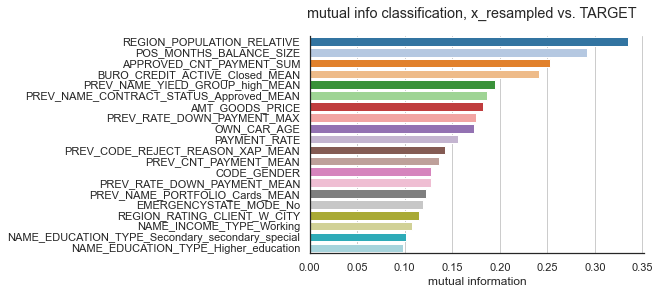

In [38]:
with timer('Mutual Information'):
    plot_mutual_information(x_sample, y_sample)
plt.suptitle(f'mutual info classification, x_resampled vs. TARGET')
to_png()
plt.show()


### Influence d'ajouter des features pour chaque model candidat

- Dans un premier temps, on essayer de determiner l'effet additif des nouveaux variables sur le score du model


In [39]:

from sklearn.model_selection import cross_val_score


def plot_k_best(model_, x_, y_, kmax=10, scoring_='roc_auc',
                kbest_score_func=mutual_info_classif, error_bars=True, show_features=True):
    """Plot la meilleure features pour un modèle donné, basé sur 10 cross_validations"""
    kmax = min(x_.shape[1], kmax)
    k_range = range(1, kmax+1)
    scores = pd.DataFrame([], columns={'k', 'col', 'score_mean', 'score_std'})
    cols = []
    for k in k_range:
        x_best = select_k_best_features(x_, y_, k)
        new_cols = set(x_best.columns)-set(cols)
        # print(f'k={k}, new cols = {new_cols}')
        for col in new_cols:
            cols.append(col)
        cv_scores = cross_val_score(
            model_, x_best, y_, cv=10, scoring=scoring_, error_score=0)
        score_mean = cv_scores.mean()
        score_std = cv_scores.std()
        if scoring_ == 'r2':
            score_mean *= 100
            score_std *= 100
        # elif scoring_.startswith('neg_'):
        #     score_mean *= -1
        scores = scores.append({'k': k, 'col': ','.join(
            new_cols), 'score_mean': score_mean, 'score_std': score_std}, ignore_index=True)

    if show_features:
        sns.scatterplot(data=scores, x='k', y='score_mean', hue='col', alpha=1)
        plt.legend(title='variable ajoutée',
                   bbox_to_anchor=(1.1, 0.5), loc="center left")
    elif error_bars:
        plt.errorbar(data=scores, x='k', y='score_mean', yerr='score_std')
    else:
        sns.scatterplot(data=scores, x='k', y='score_mean')

    if scoring_ == 'r2':
        plt.ylabel("r2 score (% variance explained)")
    # elif scoring_.startswith('neg_'):
    #     plt.ylabel(f'score ({scoring_[4:]})')
    else:
        plt.ylabel(f'score ({scoring_})')

    plt.title("Performance du modèle en fonction de nombre de variables")
    plt.xlabel("nombre de variables sélectionnées (k)")
    sns.despine()
    return scores


In [40]:
def plot_kbest_adaboost():
    from sklearn.ensemble import AdaBoostClassifier
    with timer('AdaBoost - KBest(f_classif)'):
        # quelque minutes
        x_sample, y_sample = sample_data(x_train_prep, y_train, nb=10000)
        cols = plot_k_best(AdaBoostClassifier(), x_sample,
                           y_sample, scoring_='roc_auc', kbest_score_func=f_classif)
    print(cols[:5])
    plt.suptitle('AdaBoost - KBest(f_classif), scoring = roc_auc')
    to_png()

# plot_kbest_adaboost()


Ridge - KBest(f_classif) - done in 29s
   score_mean                                     col  score_std  k
0    0.530613                            PAYMENT_RATE   0.033257  1
1    0.651467                            EXT_SOURCE_3   0.038021  2
2    0.709650                            EXT_SOURCE_2   0.021686  3
3    0.722970                            EXT_SOURCE_1   0.017656  4
4    0.709997  AMT_ANNUITY,REGION_POPULATION_RELATIVE   0.021670  5
"RidgeClassifier_-_KBest(f_classif),_scoring_=_roc_auc.png"


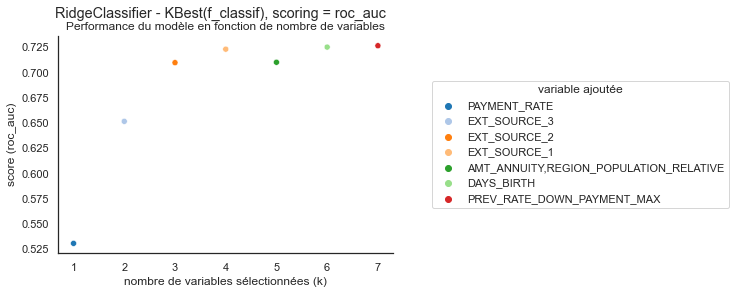

In [41]:
def plot_kbest_ridge():
    from sklearn.linear_model import RidgeClassifier
    with timer('Ridge - KBest(f_classif)'):
        # quelque minutes
        x_sample, y_sample = sample_data(x_train_prep, y_train, nb=10000)
        cols = plot_k_best(RidgeClassifier(), x_sample,
                           y_sample, scoring_='roc_auc', kmax=7, kbest_score_func=f_classif)
    print(cols[:5])
    plt.suptitle('RidgeClassifier - KBest(f_classif), scoring = roc_auc')
    to_png()


plot_kbest_ridge()


### Conclusions sur Feature Selection

Sans optimisation des hyperparamètres, on voit que 4 ou 5 variables domine la performance des modeles (ROC_AUC)


# Les métriques d'évaluation


In [42]:
from sklearn.metrics import SCORERS

print(list(SCORERS))


['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted']


Pour la classification binaire, les métriques pour estimer les erreurs entre y_pred et y_test sont :

**ROC AUC (Area Under the Curve)**

- peut être comparé entre modèles

**log loss**

- logistic loss or cross-entropy loss. Normalement utilisé s'il y a plus de 2 classes dans TARGET

**precision**
Quelle portion du target prédit sont du vrai classe ?

- precision = TP / (TP + FP)

**recall**
Quelle portion du vrai classe sont présent dans le classe prédit ?

- recall = TP / (TP + FN)

**F1-score**
Accuracy équilibré

- F1 = 2 _ (precision _ recall) / (precision + recall)
- F1 = (2 _ TP) / (2 _ TP + FP + FN)

**Fbeta-score**
Generalisation de F1-score pour mettre plus de poids sur precision (ex beta=0.5), ou pour mettre plus de poid sur recall (ex: beta=2)


### Custom Credit Scorer

Pour la banque, le cout d'un faux positif (donner un prêt à un mauvais payeur) est plus que le cout d'un faux negatif (refuser un prêt à un bon client)

Donc, il faut penaliser les faux positif plus que les faux negatif


In [43]:
def custom_credit_score(y_test, y_pred):
    """
    Penalise les prêts qui ne sont pas repayés (perte plus importante que si on ne prend pas un client bon)
    (TN - FP - 3*FN)
    """
    cm = metrics.confusion_matrix(y_test, y_pred)
    # y_true=0 (bon), y_pred=0 (bon) - ce que le banque veut donner un pret
    TN = cm[0, 0]
    # y_true=1 (mauvais), y_pred=1 (bon) - grand perte pour la banque
    FN = cm[1, 0]
    # y_true=0 (bon), y_pred=1 (mauvais) - petit perte (manque de preter à un bon client
    FP = cm[0, 1]
    # y_true=1 (mauvais), y_pred=1 (mauvais) - ce que la banque veut refuser
    TP = cm[1, 1]
    # bank_profit = TN * valeur_par_pret_fait
    # bank_loss = FN * grand_pert_mauvais_pret + FP * valeur_par_pret_perdu
    # bank_net_profit = bank_profit - bank loss
    # bank_net_profit = (TN - FP) * valeur_par_pret - FN * grand_pert_mauvais_pret
    # normalise par la taille de l'echantillon (cm.sum())
    valeur_par_pret = 1  # suppose la valeur des prêts fait ou perdus sont identiques
    # (on suppose que la cout d'un mauvais prêt et 3 fois le rentabilité d'un bon prêt)
    grand_pert_mauvais_pret = 3
    profit_score = (TN - FP - 3*FN)/cm.sum()
    return profit_score


In [44]:
from sklearn import metrics

# mise en constant pour référence ailleurs
ROC_AUC = 'roc_auc'


def performance_metrics(y_true_, y_pred_):
    """Plusieurs functions de cout (Loss)"""
    loss = dict(
        roc_auc=metrics.roc_auc_score(y_true_, y_pred_),
        logloss=metrics.log_loss(y_true_, y_pred_),
        precision=metrics.precision_score(y_true_, y_pred_),
        recall=metrics.recall_score(y_true_, y_pred_),
        f1=metrics.f1_score(y_true_, y_pred_),
        f2=metrics.fbeta_score(y_true_, y_pred_, beta=2),
        f05=metrics.fbeta_score(y_true_, y_pred_, beta=0.5),
        custom_score=custom_credit_score(y_true_, y_pred_),
    )
    for metric in loss.keys():
        loss[metric] = round(loss[metric], 3)
    return loss


y_true1 = [0, 0, 1, 1]
y_pred1 = [0, 1, 0, 1]
print(metrics.confusion_matrix(y_true1, y_pred1))
print(performance_metrics(y_true1, y_pred1))


[[1 1]
 [1 1]]
{'roc_auc': 0.5, 'logloss': 17.27, 'precision': 0.5, 'recall': 0.5, 'f1': 0.5, 'f2': 0.5, 'f05': 0.5, 'custom_score': -0.75}


### Accumulation des performances des modèles


In [45]:
df_resultats = pd.DataFrame()


def add_perf_metrics(df: pd.DataFrame = None, model_name: str = 'none', ARI: float = 0, k: int = 0, **kwargs):
    global df_resultats
    if df is None:
        df = df_resultats
    """ajout les resultats d'un model """
    resultats = dict(model=model_name)
    resultats = dict(**resultats, **kwargs)
    df = df.append(resultats, ignore_index=True)
    return df


# test
add_perf_metrics(pd.DataFrame(), optimizer='adam', k=7)


,model,optimizer
0,none,adam


## Teste des métriques de performance


In [46]:
y_true1 = [0, 0, 1, 1]
y_pred1 = [0, 0, 1, 1]
perf = performance_metrics(y_true1, y_pred1)
df_temp = add_perf_metrics(pd.DataFrame(), 'perfect', **perf)
y_true1 = [0, 0, 1, 1]
y_pred1 = [0, 1, 0, 1]
perf = performance_metrics(y_true1, y_pred1)
df_temp = add_perf_metrics(df_temp, '1-each (TN,FN,FP,TP)', **perf)
y_true1 = [1, 1, 0, 1]
y_pred1 = [0, 0, 0, 1]
perf = performance_metrics(y_true1, y_pred1)
df_temp = add_perf_metrics(df_temp, 'a few bad payers', **perf)
y_true1 = [1, 1, 1, 1, 0, 1]
y_pred1 = [0, 0, 0, 0, 0, 1]
perf = performance_metrics(y_true1, y_pred1)
df_temp = add_perf_metrics(df_temp, 'many bad payers', **perf)
y_true1 = [0, 0, 0, 1]
y_pred1 = [0, 1, 1, 1]
perf = performance_metrics(y_true1, y_pred1)
df_temp = add_perf_metrics(df_temp, 'a few wrong refusals', **perf)
y_true1 = [0, 0, 0, 0, 0, 1]
y_pred1 = [0, 1, 1, 1, 1, 1]
perf = performance_metrics(y_true1, y_pred1)
df_temp = add_perf_metrics(df_temp, 'many wrong refusals', **perf)
df_temp.sort_values(by='custom_score')


,custom_score,f05,f1,f2,logloss,model,precision,recall,roc_auc
3,-1.833,0.556,0.333,0.238,23.026,many bad payers,1.000,0.200,0.600
2,-1.250,0.714,0.500,0.385,17.269,a few bad payers,1.000,0.333,0.667
1,-0.750,0.500,0.500,0.500,17.270,"1-each (TN,FN,FP,TP)",0.500,0.500,0.500
5,-0.500,0.238,0.333,0.556,23.026,many wrong refusals,0.200,1.000,0.600
4,-0.250,0.385,0.500,0.714,17.270,a few wrong refusals,0.333,1.000,0.667
0,0.500,1.000,1.000,1.000,0.000,perfect,1.000,1.000,1.000


On voit qu'on peut utiliser F2-score, par exemple, au lieu de custom scorer

On essaie d'optimiser roc_auc, en suivant custom_score et f2_score


In [47]:
custom_scorer = metrics.make_scorer(
    custom_credit_score, greater_is_better=True)
f2_scorer = metrics.make_scorer(
    metrics.fbeta_score, greater_is_better=True, beta=2)

# GridsearchCV attend un dictionnaire si on fourni plusieurs scorers
CV_SCORERS = {
    'roc_auc': 'roc_auc',
    'custom_scorer': custom_scorer,
    'f2_scorer': f2_scorer
}


# GridSearch et évaluation


## Gridsearch sur un model pipeline

On utilise sklearn pipeline (ou imblearn pipelibe si on ajout de sampling dnas le pipeline)


In [48]:
# Test GridSearch
grid_search = GridSearchCV(estimator=test_model,
                           param_grid=param_grid,
                           scoring=CV_SCORERS,
                           refit='roc_auc',
                           cv=stratified_kfold,
                           verbose=2,
                           return_train_score=True,
                           n_jobs=-1)


grid_search.fit(x_train_prep, y_train)
cv_score = grid_search.best_score_
test_score = grid_search.score(x_test_prep, y_test)
df_cv = pd.DataFrame(grid_search.cv_results_)
df_cv.head()


Fitting 5 folds for each of 7 candidates, totalling 35 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__alpha,params,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,split0_train_roc_auc,split1_train_roc_auc,split2_train_roc_auc,split3_train_roc_auc,split4_train_roc_auc,mean_train_roc_auc,std_train_roc_auc,split0_test_custom_scorer,split1_test_custom_scorer,split2_test_custom_scorer,split3_test_custom_scorer,split4_test_custom_scorer,mean_test_custom_scorer,std_test_custom_scorer,rank_test_custom_scorer,split0_train_custom_scorer,split1_train_custom_scorer,split2_train_custom_scorer,split3_train_custom_scorer,split4_train_custom_scorer,mean_train_custom_scorer,std_train_custom_scorer,split0_test_f2_scorer,split1_test_f2_scorer,split2_test_f2_scorer,split3_test_f2_scorer,split4_test_f2_scorer,mean_test_f2_scorer,std_test_f2_scorer,rank_test_f2_scorer,split0_train_f2_scorer,split1_train_f2_scorer,split2_train_f2_scorer,split3_train_f2_scorer,split4_train_f2_scorer,mean_train_f2_scorer,std_train_f2_scorer
0,0.710619,0.170703,0.051387,0.012876,0.001,{'clf__alpha': 0.001},0.724055,0.720487,0.759196,0.748343,0.746310,0.739678,0.014916,5,0.769567,0.770443,0.763460,0.764231,0.761828,0.765906,0.003447,0.31625,0.236875,0.30875,0.328125,0.30125,0.29825,0.031946,3,0.324219,0.318906,0.314063,0.311719,0.300000,0.313781,0.008117,0.418288,0.404914,0.424301,0.426889,0.421860,0.419250,0.007709,3,0.443451,0.450957,0.442584,0.442721,0.436019,0.443146,0.004741
1,0.746412,0.133843,0.048671,0.005897,0.01,{'clf__alpha': 0.01},0.724055,0.720487,0.759196,0.748343,0.746310,0.739678,0.014916,5,0.769567,0.770442,0.763460,0.764231,0.761828,0.765906,0.003447,0.31625,0.236875,0.30875,0.328125,0.30125,0.29825,0.031946,3,0.324219,0.318906,0.314063,0.311719,0.300000,0.313781,0.008117,0.418288,0.404914,0.424301,0.426889,0.421860,0.419250,0.007709,3,0.443451,0.450957,0.442584,0.442721,0.436019,0.443146,0.004741
2,0.597602,0.057755,0.046277,0.010320,0.1,{'clf__alpha': 0.1},0.724055,0.720487,0.759196,0.748333,0.746310,0.739676,0.014915,7,0.769568,0.770442,0.763459,0.764232,0.761829,0.765906,0.003447,0.31625,0.236875,0.30875,0.328125,0.30125,0.29825,0.031946,3,0.324219,0.318906,0.314063,0.311719,0.300000,0.313781,0.008117,0.418288,0.404914,0.424301,0.426889,0.421860,0.419250,0.007709,3,0.443451,0.450957,0.442584,0.442721,0.436019,0.443146,0.004741
3,0.514623,0.021109,0.042086,0.004297,1,{'clf__alpha': 1},0.724080,0.720498,0.759191,0.748369,0.746315,0.739691,0.014910,4,0.769563,0.770443,0.763455,0.764234,0.761831,0.765905,0.003446,0.31625,0.236875,0.30875,0.328125,0.30125,0.29825,0.031946,3,0.323750,0.318906,0.314063,0.312031,0.300000,0.313750,0.007984,0.418288,0.404914,0.424301,0.426889,0.421860,0.419250,0.007709,3,0.442350,0.450957,0.442584,0.442826,0.436019,0.442947,0.004747
4,0.494876,0.010525,0.043882,0.003154,10,{'clf__alpha': 10},0.724096,0.720549,0.759191,0.748390,0.746362,0.739717,0.014900,3,0.769580,0.770454,0.763455,0.764257,0.761841,0.765917,0.003448,0.31625,0.236875,0.30875,0.328125,0.30250,0.29850,0.031973,2,0.324062,0.318906,0.313750,0.311094,0.300625,0.313688,0.007902,0.418288,0.404914,0.424301,0.426889,0.422265,0.419331,0.007738,2,0.442456,0.450957,0.442478,0.440650,0.436226,0.442553,0.004781


## Cross-validation parameter selection

- il faut valider les paramètres sélectionnés pendant grid search

### Validation curves (pour sélection d'hyperparamètres)


In [49]:
def plot_best_param_scores(gs, param='alpha', model_name='', score='roc_auc', logx=False):
    cv = pd.DataFrame.from_dict(gs.cv_results_)
    param_key = f'param_{param}'
    if not param_key in cv.columns:
        return f'{param_key} not in cross-validation results'

    # filter by all best params, except chosen param
    filtre = cv.index == cv.index
    best_param = gs.best_params_[param]
    if not isinstance(best_param, (int, float)):
        return 'param is not a number'
    for key in gs.best_params_.keys():
        # print(f'key={key}, param_key={param_key}')
        if key != param:
            filtre &= cv[f'param_{key}'] == gs.best_params_[key]

    res = cv[filtre]
    if len(res) < 3:
        print('filter < 3 results')
        return res

    if f'mean_train_{score}' in res.columns:
        plt.errorbar(x=res[param_key], y=res[f'mean_train_{score}'],
                     yerr=res[f'std_train_{score}'], label='cv train')
    plt.errorbar(x=res[param_key], y=res[f'mean_test_{score}'],
                 yerr=res[f'std_test_{score}'], label='cv test')
    ax = plt.gca()

    y_min, y_max = plt.ylim()
    ax.vlines(best_param, y_min, y_max,
              label=f'best value : {param} = {best_param:.3f}', linestyle="--", color="tab:orange")
    plt.legend(loc='best')
    plt.xlabel(f'paramètre : {param}')
    if is_log_scale(res[param_key].values) or logx:
        plt.xscale('log')
    plt.ylabel(f'score ({score})')
    plt.suptitle(f'{model_name}')
    plt.title(f'Validation Curve (paramètre : {param})')
    to_png(f'{model_name} - Validation Curve (paramètre : {param})')
    plt.show()


In [50]:
# Test
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeClassifier

param_grid = {
    # 'fit_intercept': [True, False],
    # 'clf__class_weight': [None, 'balanced'],
    'clf__alpha': np.logspace(-3, 5, 20)
},

gs = GridSearchCV(test_model,
                  param_grid=param_grid,
                  return_train_score=True,
                  scoring=CV_SCORERS,
                  refit='roc_auc')


gs.fit(x_train_prep, y_train)
gs.score(x_test_prep, y_test)
cv = pd.DataFrame.from_dict(gs.cv_results_)
cv.head()


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__alpha,params,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,split0_train_roc_auc,split1_train_roc_auc,split2_train_roc_auc,split3_train_roc_auc,split4_train_roc_auc,mean_train_roc_auc,std_train_roc_auc,split0_test_custom_scorer,split1_test_custom_scorer,split2_test_custom_scorer,split3_test_custom_scorer,split4_test_custom_scorer,mean_test_custom_scorer,std_test_custom_scorer,rank_test_custom_scorer,split0_train_custom_scorer,split1_train_custom_scorer,split2_train_custom_scorer,split3_train_custom_scorer,split4_train_custom_scorer,mean_train_custom_scorer,std_train_custom_scorer,split0_test_f2_scorer,split1_test_f2_scorer,split2_test_f2_scorer,split3_test_f2_scorer,split4_test_f2_scorer,mean_test_f2_scorer,std_test_f2_scorer,rank_test_f2_scorer,split0_train_f2_scorer,split1_train_f2_scorer,split2_train_f2_scorer,split3_train_f2_scorer,split4_train_f2_scorer,mean_train_f2_scorer,std_train_f2_scorer
0,0.265479,0.014694,0.020549,0.002152,0.001,{'clf__alpha': 0.001},0.707326,0.724664,0.790712,0.725771,0.76222,0.742139,0.030159,12,0.770703,0.771634,0.752082,0.771581,0.761210,0.765442,0.007748,0.270625,0.265625,0.325,0.293125,0.305,0.291875,0.021962,8,0.31,0.329375,0.292969,0.329219,0.312812,0.314875,0.013593,0.377268,0.383523,0.474383,0.384615,0.430622,0.410082,0.037382,6,0.43956,0.449927,0.425355,0.444956,0.438428,0.439646,0.008242
1,0.236562,0.008115,0.021141,0.003806,0.00263665,{'clf__alpha': 0.0026366508987303583},0.707326,0.724664,0.790712,0.725771,0.76222,0.742139,0.030159,12,0.770703,0.771634,0.752082,0.771581,0.761210,0.765442,0.007747,0.270625,0.265625,0.325,0.293125,0.305,0.291875,0.021962,8,0.31,0.329375,0.292969,0.329219,0.312812,0.314875,0.013593,0.377268,0.383523,0.474383,0.384615,0.430622,0.410082,0.037382,6,0.43956,0.449927,0.425355,0.444956,0.438428,0.439646,0.008242
2,0.242952,0.004910,0.018556,0.002423,0.00695193,{'clf__alpha': 0.0069519279617756054},0.707326,0.724664,0.790712,0.725771,0.76222,0.742139,0.030159,12,0.770703,0.771634,0.752082,0.771581,0.761210,0.765442,0.007747,0.270625,0.265625,0.325,0.293125,0.305,0.291875,0.021962,8,0.31,0.329375,0.292969,0.329219,0.312812,0.314875,0.013593,0.377268,0.383523,0.474383,0.384615,0.430622,0.410082,0.037382,6,0.43956,0.449927,0.425355,0.444956,0.438428,0.439646,0.008242
3,0.242546,0.005057,0.020565,0.002231,0.0183298,{'clf__alpha': 0.018329807108324356},0.707326,0.724664,0.790712,0.725771,0.76222,0.742139,0.030159,12,0.770703,0.771634,0.752082,0.771582,0.761210,0.765442,0.007747,0.270625,0.265625,0.325,0.293125,0.305,0.291875,0.021962,8,0.31,0.329375,0.292969,0.329219,0.312812,0.314875,0.013593,0.377268,0.383523,0.474383,0.384615,0.430622,0.410082,0.037382,6,0.43956,0.449927,0.425355,0.444956,0.438428,0.439646,0.008242
4,0.241163,0.004944,0.020347,0.002330,0.0483293,{'clf__alpha': 0.04832930238571752},0.707326,0.724664,0.790712,0.725771,0.76222,0.742139,0.030159,12,0.770702,0.771634,0.752083,0.771582,0.761209,0.765442,0.007747,0.270625,0.265625,0.325,0.293125,0.305,0.291875,0.021962,8,0.31,0.329375,0.292969,0.329219,0.312812,0.314875,0.013593,0.377268,0.383523,0.474383,0.384615,0.430622,0.410082,0.037382,6,0.43956,0.449927,0.425355,0.444956,0.438428,0.439646,0.008242


"RidgeClassifier_-_Validation_Curve_(paramètre_-_clf__alpha).png"


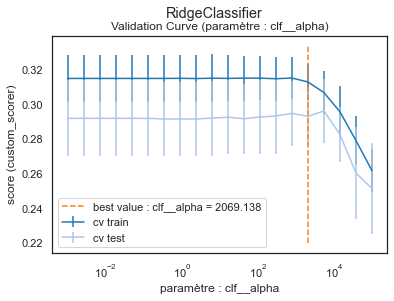

In [51]:
# plot_best_param_scores(gs, param='alpha', score='roc_auc', model_name='RidgeClassifier')
plot_best_param_scores(
    gs, param='clf__alpha', score='custom_scorer', model_name='RidgeClassifier')


### Time model

On ne mesure pas le temp pour le GridSearchCV, car ça dépend du nombre de choix d'hyperparamètres pour chaque modèle

On mesure le temp d'entrainement d'un modèle avec des paramètres choisis


## Trouve le meilleur modèle avec GridSearch

### Choix de scorer pour GridSearch


In [52]:
from sklearn.model_selection import GridSearchCV


def search_best_model(model_name, estimator, param_grid,
                      x_train, y_train,
                      scoring=['roc_auc'],
                      refit_scorer='roc_auc'):

    gs = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        cv=5, n_jobs=-1,
        verbose=1,
        scoring=scoring,
        refit=refit_scorer,
        return_train_score=True)

    # lance le gridsearch
    start = get_time()
    gs.fit(x_train, y_train)
    end = get_time()

    cv_time = round(end-start, 3)
    print(f'GridSearchCV took {cv_time} s')

    # plot param_grid curves (verification que les best_params sont trouvés)
    for param in gs.best_params_:
        print(f'param : {param}')
        plot_best_param_scores(gs, param, model_name, score=refit_scorer)
        plt.show()

    return gs


Fitting 5 folds for each of 20 candidates, totalling 100 fits
GridSearchCV took 25.515 s
param : clf__alpha
"Test_model_-_Validation_Curve_(paramètre_-_clf__alpha).png"


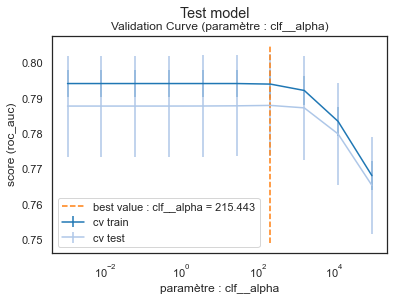

param : clf__fit_intercept
filter < 3 results
{'clf__alpha': 215.44346900318823, 'clf__fit_intercept': True}


In [53]:
# Test
from sklearn.linear_model import RidgeClassifier


param_grid = {
    'clf__fit_intercept': [True, False],
    'clf__alpha': np.logspace(-3, 5, 10)
},

gs = search_best_model('Test model', test_model,
                       param_grid, x_sample, y_sample)
print(gs.best_params_)


## Propriétés du best modèle


#### Get estimator

Chaque pipeline contient des regressors dans des positions différents:

- (estimator) - l'estimator est à la racine
  - `gs.best_estimator_`
- (clf, estimator) - l'estimator est un named step 'clf'
  - `gs.best_estimator_.named_steps['clf']`
- (clf, TransformedTargetClassifier(clf=estimator))
  - `gs.best_estimator_.named_steps['clf'].regressor_`

Pour éviter des erreurs en changeant le pipeline, voici quelques utilitaires pour retourner l'estimateur, son classname, les attributs, les feature*importances*, etc


In [54]:
def get_classifier(model):
    """Trouver le classifier dans un pipeline"""
    if hasattr(model, 'coefs_') or hasattr(model, 'intercept_'):
        return model
    if hasattr(model, 'feature_importances_'):
        return model
    if hasattr(model, 'estimators_'):
        return model

    if hasattr(model, 'regressor_'):
        return get_classifier(model.regressor_)

    if hasattr(model, 'named_steps'):
        try:
            clf = model.named_steps['clf']
        except:
            clf = None
        if not clf is None:
            return get_classifier(clf)

    if hasattr(model, 'clf'):
        return get_classifier(model.clf)

    if isinstance(model, BaseEstimator):
        # if hasattr(model, 'coef_') or hasattr(model, 'feature_importances_'):
        return model
    else:
        return 'classifier not found'


# test 1
get_classifier(test_model)


RidgeClassifier()

In [55]:
# test 2
get_classifier(RidgeClassifier())


RidgeClassifier()

In [56]:
# test 3
get_classifier(gs.best_estimator_)


RidgeClassifier(alpha=215.44346900318823)

In [57]:

def get_classname(estimator):
    return estimator.__class__.__name__


def get_model_classname(model):
    estimator = get_classifier(model)
    return get_classname(estimator)


def get_model_feature_importances(model):
    estimator = get_classifier(model)
    return getattr(estimator, 'feature_importances_', None)


def get_model_estimators(model):
    estimator = get_classifier(model)
    return getattr(estimator, 'estimators_', None)


In [58]:
def filtered_list(values, mask):
    res = [i for (i, v) in zip(values, mask) if v]
    return res


def get_step(model, step_name='k_best'):
    if hasattr(model, 'named_steps'):
        try:
            step = model.named_steps[step_name]
        except:
            step = None
        return step
    name = get_classname(model)
    if name == step_name:
        return model
    return None


def get_kbest_features(model, features_in=None):
    """cv.best_estimator_.named_steps['k_best'].get_support()"""
    k_best = get_step(model, 'k_best')
    if not k_best is None:
        if hasattr(k_best, 'get_support'):
            mask = k_best.get_support()
            if len(mask) == len(features_in):
                return filtered_list(features_in, mask)
    return None


### Propriétés du best classifier


In [59]:
def get_classifier_attributs(gs, public_only=True):
    model = get_classifier(gs.best_estimator_)
    attributs = dir(model)
    if public_only:
        attributs = [a for a in attributs if not a.startswith('_')]
    print(attributs)


get_classifier_attributs(gs)


['alpha', 'class_weight', 'classes_', 'coef_', 'copy_X', 'decision_function', 'fit', 'fit_intercept', 'get_params', 'intercept_', 'max_iter', 'n_features_in_', 'n_iter_', 'normalize', 'positive', 'predict', 'random_state', 'score', 'set_params', 'solver', 'tol']


## Comparaison des models (score, temps, params)


### Add Model Score (df_scores)

Le score du model est composé de:

- paramêtres (nom de model(algorithme/dataset), best_params)
- gridsearch scores (train/test) sur x_train, y_train
- validation performance metrics sur x_test, y_test

Les temps total de gridsearch, plus le temps d'entrainement du model avec best_params sont aussi enregistrés


In [60]:
from sklearn.base import BaseEstimator
metrics_columns = list(performance_metrics(y_true1, y_pred1).keys())
cols = ['model_name', 'params', 'train_time', 'gridsearch_time',
        'mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score'] + metrics_columns
print(cols)
df_scores = pd.DataFrame(columns=cols)


def add_model_score(model_name: str,
                    model: BaseEstimator,
                    params: dict,
                    train_time, gridsearch_time,
                    mean_train_score, std_train_score,
                    mean_test_score, std_test_score,
                    metrics):
    """Ajouter les resultats de gridsearch sur xtrain,ytrain et score sur xtest,ytest aux scores"""

    global df_scores
    print(f'add_model_score, model = {model_name}')

    # identification du model
    model_keys = dict(
        model_name=model_name,
        model=model,
    )

    # params contient gridsearch.best_params_
    gridsearch_results = dict(
        params=params,
        mean_train_score=round_digits(mean_train_score, 3),
        std_train_score=round_digits(std_train_score, 3),
        mean_test_score=round_digits(mean_test_score, 3),
        std_test_score=round_digits(std_test_score, 3),
        gridsearch_time=gridsearch_time,
        train_time=train_time,

    )
    # validation scores sont dans metrics

    row = dict(**model_keys, **gridsearch_results, **metrics)

    df_scores = df_scores.append(row, ignore_index=True)
    return df_scores


['model_name', 'params', 'train_time', 'gridsearch_time', 'mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score', 'roc_auc', 'logloss', 'precision', 'recall', 'f1', 'f2', 'f05', 'custom_score']


### Validation (score) d'un model

#### Récupérer les paramêtres / scores de GridSearch et prédire sur le jeu de données "test"


In [61]:

def score_model(model_name, gs,
                x_train_, y_train_, x_test_, y_test_, score='roc_auc') -> pd.Series:
    """Après grid search, récuperer le best model, fit sur train et score sur test, enregistre dans df_scores"""
    global df_scores
    best_model = gs.best_estimator_
    best_params = gs.best_params_  # gs.cv_results_["params"][gs.best_index_]
    best_cv_score = gs.best_score_  # mean_test_score
    refit_time = gs.refit_time_  # train_time
    cv = pd.DataFrame(gs.cv_results_)
    mean_train_score = cv[f'mean_train_{score}'][gs.best_index_].mean()
    std_train_score = cv[f'std_train_{score}'][gs.best_index_].mean()
    # gs.best_score_
    mean_test_score = cv[f'mean_test_{score}'][gs.best_index_].mean()
    std_test_score = cv[f'std_test_{score}'][gs.best_index_].mean()
    mean_fit_time = cv[f'mean_fit_time'].mean()
    mean_score_time = cv[f'mean_score_time'].mean()
    fit_time = len(cv)*mean_fit_time

    n_splits = gs.n_splits_  # number of splits of training data
    n_iter = len(cv)  # Iterations per split
    gridsearch_time = (mean_fit_time + mean_score_time) * n_splits * n_iter

    # print(f'Best Estimator: {best_model}')
    print(f'Best Parameters: {best_params}')
    print(f'Best Training Score ({score}): {mean_train_score:.3f}')
    print(f'Best Test Score ({score}) : {mean_test_score:.3f}')

    start = get_time()
    best_model = gs.best_estimator_
    best_model.fit(x_train_, y_train_)
    end = get_time()
    # temps d'entrainement avec best_params
    train_time = round(end-start, 3)
    y_pred = best_model.predict(x_test_)

    print(
        f'time_model ({model_name}; training time = {train_time} s; gridsearch time = {gridsearch_time} s')

    metrics = performance_metrics(y_test_, y_pred)

    add_model_score(model_name,
                    best_model, best_params,
                    train_time, gridsearch_time,
                    mean_train_score, std_train_score,
                    mean_test_score, std_test_score,
                    metrics,
                    )
    return y_pred


y_pred = score_model('test_model', gs, x_train_prep,
                     y_train, x_test_prep, y_test)


Best Parameters: {'clf__alpha': 215.44346900318823, 'clf__fit_intercept': True}
Best Training Score (roc_auc): 0.794
Best Test Score (roc_auc) : 0.788
time_model (test_model; training time = 0.389 s; gridsearch time = 176.06454348564145 s
add_model_score, model = test_model


In [62]:
# test add_model_scores


Fitting 5 folds for each of 20 candidates, totalling 100 fits
GridSearchCV took 6.962 s
param : clf__alpha
"RidgeClassifier_-_Validation_Curve_(paramètre_-_clf__alpha).png"


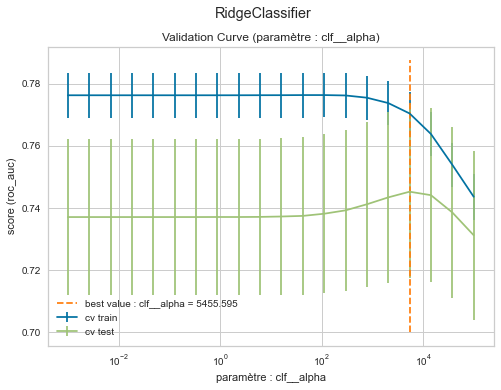

Best Parameters: {'clf__alpha': 5455.594781168515}
Best Training Score (roc_auc): 0.770
Best Test Score (roc_auc) : 0.745
time_model (RidgeClassifier; training time = 0.08 s; gridsearch time = 19.116391420364383 s
add_model_score, model = RidgeClassifier


In [82]:
model_name = 'RidgeClassifier'
smt = SMOTE(random_state=RANDOM_SEED)
ridge = RidgeClassifier()
model_pipeline = imbpipeline.Pipeline([
    ('sampling', smt),
    ('clf', ridge)])
param_grid = {'clf__alpha': np.logspace(-3, 5, 20)}
gs = search_best_model(model_name, model_pipeline,
                       param_grid, x_train_prep, y_train)
y_pred = score_model(model_name, gs, x_train_prep,
                     y_train, x_test_prep, y_test)


## Visualisations


### Confusion Matrix


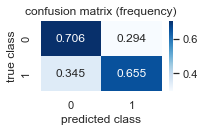

In [64]:
Serie = list or np.ndarray or pd.Series


def plot_confusion_matrix_heatmap(y_true: Serie, y_pred: Serie, normalize=True,
cmap='Blues', ax=None, figsize=(6, 4) ):
    """
    plot confusion matrix as heatmap

    Parameters
    ----------
    y_true : labels (number or string list, 1-d array or series)
    y_pred : labels (number or string list, 1-d array or series)
    cmap: colors
    figsize: figure size
    """
    # df_cm = confusion_matrix_crosstab(y_true, y_pred, normalize=normalize)
    df_cm = metrics.confusion_matrix(y_true, y_pred, normalize='true')
    if ax is None:
        _, ax = plt.subplots(figsize=figsize)
    if normalize:
        sns.heatmap(df_cm, annot=True, cmap=cmap, fmt='.3f', ax=ax)
        plt.title('confusion matrix (frequency)')
    else:
        sns.heatmap(df_cm, annot=True, cmap=cmap, fmt='.0f',ax=ax)
        plt.title('confusion matrix (count)')
    plt.xlabel('predicted class')
    plt.ylabel('true class')
    plt.tight_layout(h_pad=0.2, w_pad=0.2)

plot_confusion_matrix_heatmap(y_test,y_pred, figsize=(3,2))

### AUC (Area Under the Curve)


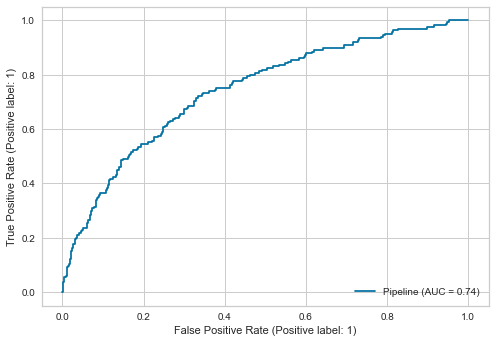

In [87]:
def plot_roc_from_clf(clf: BaseEstimator, x_test_, y_test_, **kwargs):
    display = metrics.RocCurveDisplay.from_estimator(
        clf, x_test_, y_test_, **kwargs)

model_pipeline.set_params(**dict(gs.best_params_))
model_pipeline.fit(x_train_prep,y_train)
plot_roc_from_clf(model_pipeline,x_test_prep,y_test)

## Confusion matrix et ROC Curve

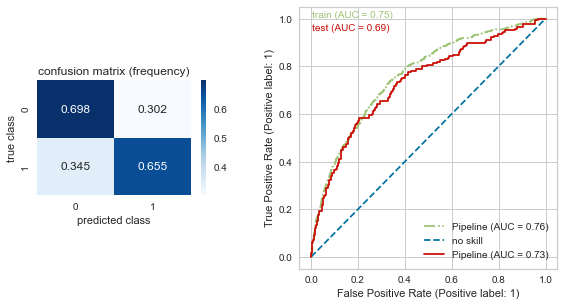

In [88]:

def plot_cm_roc(model:BaseEstimator, gs:GridSearchCV, x_train_, y_train_, x_test_,y_test_):
    """plot confusion matrix and ROC curve"""
    # best_clf: BaseEstimator = get_classifier(gs.best_estimator_)
    best_params = gs.best_params_
    # model can be a classifier or a pipeline with a classifier
    model.set_params(**dict(best_params))
    model.fit(x_train_, y_train_)
    y_pred_ = model.predict(x_test_)
    y_pred_ = model.predict(x_test_)
  
    fig, _ = plt.subplots(figsize=(8, 4))
    gspec = fig.add_gridspec(8,8)
    ax = plt.subplot(gspec[2:6, :3])
    ax=plot_confusion_matrix_heatmap(y_test_,y_pred_,ax=ax)

    ax = plt.subplot(gspec[:, 4:])
    train_label= f'train (AUC = {gs.best_score_:.2f})'
    auc_test=model.score(x_test_,y_test_)
    test_label= f'test (AUC = {auc_test:.2f})'
    plot_roc_from_clf(model, x_train_, y_train_, c='g', ls='-.', ax=ax)
    ax.plot([0, 1], [0, 1], color='b', ls='--', label='no skill')
    add_text(ax,0.05,0.95,train_label, c='g', fontsize=10)
    add_text(ax,0.05,0.9,test_label, c='r', fontsize=10)
    # ax.grid(False)
    plot_roc_from_clf(model, x_test_, y_test_, c='r', ax=ax)

plot_cm_roc(test_model,gs,x_train_prep,y_train,x_test_prep,y_test)